# S09 T02: Aprenentatge Supervisat - Regressions

## Nivell 0. Exercici 0. Partim del conjunt de dadesDelayedFlights.csv 

In [1]:
# Pandas for managing datasets
import pandas as pd
import numpy as np
import random 

# Matplotlib for additional customization
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

#preprocessing and analysis
from scipy import stats
from sklearn import preprocessing
from scipy.stats import boxcox 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Import necessary modules
from math import sqrt
from sklearn.metrics import r2_score

from sklearn import svm

## Nivell 0: We Should first clean the data, handle missing values and so on.

In [2]:
vuelos = pd.read_csv("DelayedFlights.csv")
vuelos.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [3]:
vuelos.shape

(1936758, 30)

Variables Description

- __Year.__ year of the flight (stored as factor).

- __Month.__ month of the flight (stored as factor).

- __DayOfMonth.__ day of the month (1 to 31) (stored as integer).

- __DayOfWeek.__ day of the week (stored as factor).

- __DepTime.__ actual departure time (stored as float).

- __CRSDepTime.__ scheduled departure time (stored as float).

- __ArrTime.__ actual arrival time (stored as float).

- __CRSArrTime.__ scheduled arrival time (stored as float).

- __UniqueCarrier.__ carrier ID (stored as factor).

- __FlightNum.__ flight number (stored as factor).

- __TailNum.__ plane's tail number (stored as factor).

- __ActualElapsedTime.__ actual elapsed time of the flight, in minutes (stored as integer).

- __CRSElapsedTime.__ scheduled elapsed time of the flight, in minutes (stored as integer).

- __AirTime.__ airborne time for the flight, in minutes (stored as integer).

- __ArrDelay.__ arrival delay, in minutes (stored as integer).

- __DepDelay.__ departure delay, in minutes (stored as integer).

- __Origin.__ originating airport (stored as factor).

- __Dest.__ destination airport (stored as factor).

- __Distance.__ flight distance (stored as integer).

- __TaxiIn.__ taxi time from wheels down to arrival at the gate, in minutes (stored as integer).

- __TaxiOut.__ taxi time from departure from the gate to wheels up, in minutes (stored as integer).

- __Cancelled.__ cancellation status (stored as logical).

- __CancellationCode.__ cancellation code, if applicable (stored as factor).

- __Diverted.__ diversion status (stored as logical).

- __CarrierDelay.__ delay, in minutes, attributable to the carrier (stored integer).

- __WeatherDelay.__ delay, in minutes, attributable to weather factors (stored as integer).

- __NASDelay.__ delay, in minutes, attributable to the National Aviation System (stored as integer).

- __SecurityDelay.__ delay, in minutes, attributable to security factors (stored as integer).

- __LateAircraftDelay.__ delay, in minutes, attributable to late-arriving aircraft (stored as integer).

__Source__

__AirlineData87to08: Airline On-Time Performance Data__ https://docs.microsoft.com/en-us/machine-learning-server/r-reference/revoscaler/airlinedata87to08

In [4]:
# Deleting columns are not interesting for analysis
# Year, because is 2008 for all the DF
# Cancelled, has the value 0 for all the DF
df = vuelos.drop(["Unnamed: 0" ,"TaxiIn", "TaxiOut", "FlightNum", "Diverted","TailNum","Year", "Cancelled", "CancellationCode"], axis=1)
df.shape

(1936758, 21)

In [5]:
# Deleting rows with null data, based on ArrDelay variable
df.dropna(subset=["ArrDelay"], inplace=True)
df["ArrDelay"].unique()

array([ -14.,    2.,   14., ...,  880., 1279.,  991.])

In [6]:
# Also, we remove all the rows that are negative values for the column ArrDelay.
# Additionally, the Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later 
# than its scheduled time

df = df[df.ArrDelay >= 15]  
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,...,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3,1,3,4,1829.0,1755,1959.0,1925,WN,90.0,90.0,...,34.0,34.0,IND,BWI,515,2.0,0.0,0.0,0.0,32.0
5,1,3,4,1937.0,1830,2037.0,1940,WN,240.0,250.0,...,57.0,67.0,IND,LAS,1591,10.0,0.0,0.0,0.0,47.0
7,1,3,4,1644.0,1510,1845.0,1725,WN,121.0,135.0,...,80.0,94.0,IND,MCO,828,8.0,0.0,0.0,0.0,72.0
9,1,3,4,1452.0,1425,1640.0,1625,WN,228.0,240.0,...,15.0,27.0,IND,PHX,1489,3.0,0.0,0.0,0.0,12.0
11,1,3,4,1323.0,1255,1526.0,1510,WN,123.0,135.0,...,16.0,28.0,IND,TPA,838,0.0,0.0,0.0,0.0,16.0


In [8]:
df.shape

(1247488, 21)

In [9]:
# We are going to do a comparison using the last five variables related to delay categories 
# Creating a new variable with the sum of all the five
# We verify that ArrDelay is exactly the same that the new variable created. 
# The sum of all the Delay categories are equal to ArrDelay
df["TotalDelay"] = df["CarrierDelay"]+df["WeatherDelay"]+df["NASDelay"]+df["SecurityDelay"]+df["LateAircraftDelay"]
    
df[["TotalDelay","ArrDelay"]]

,TotalDelay,ArrDelay
3,34.0,34.0
5,57.0,57.0
7,80.0,80.0
9,15.0,15.0
11,16.0,16.0
...,...,...
1936751,64.0,64.0
1936752,17.0,17.0
1936753,25.0,25.0
1936754,75.0,75.0


In [10]:
# So, is not neccesary to delete NaN rows in all these variables.
# We just need to replace NaN for 0, in order to have a valid value.

df["CarrierDelay"].fillna(0, inplace = True)
df["WeatherDelay"].fillna(0, inplace = True)
df["NASDelay"].fillna(0, inplace = True)
df["SecurityDelay"].fillna(0, inplace = True)
df["LateAircraftDelay"].fillna(0, inplace = True)
df[["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]]

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3,2.0,0.0,0.0,0.0,32.0
5,10.0,0.0,0.0,0.0,47.0
7,8.0,0.0,0.0,0.0,72.0
9,3.0,0.0,0.0,0.0,12.0
11,0.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...
1936751,51.0,0.0,13.0,0.0,0.0
1936752,0.0,0.0,0.0,0.0,17.0
1936753,3.0,0.0,0.0,0.0,22.0
1936754,0.0,57.0,18.0,0.0,0.0


In [11]:
# Drop the variable we created for the comparison (TotalDelay)
del df['TotalDelay']

In [12]:
# Random sample to work with instead a big mount of data.

df_sample = df.sample(n = 5000, random_state= 123)
df_sample.shape

(5000, 21)

__Relationship between variables__ The correlation matrix show us if two variables have a linear relationship and the strength of that relationship.

<ipython-input-13-394a0d47979c>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corrmat, dtype=np.bool)


Text(0.5, 1.0, 'Correlation matrix')

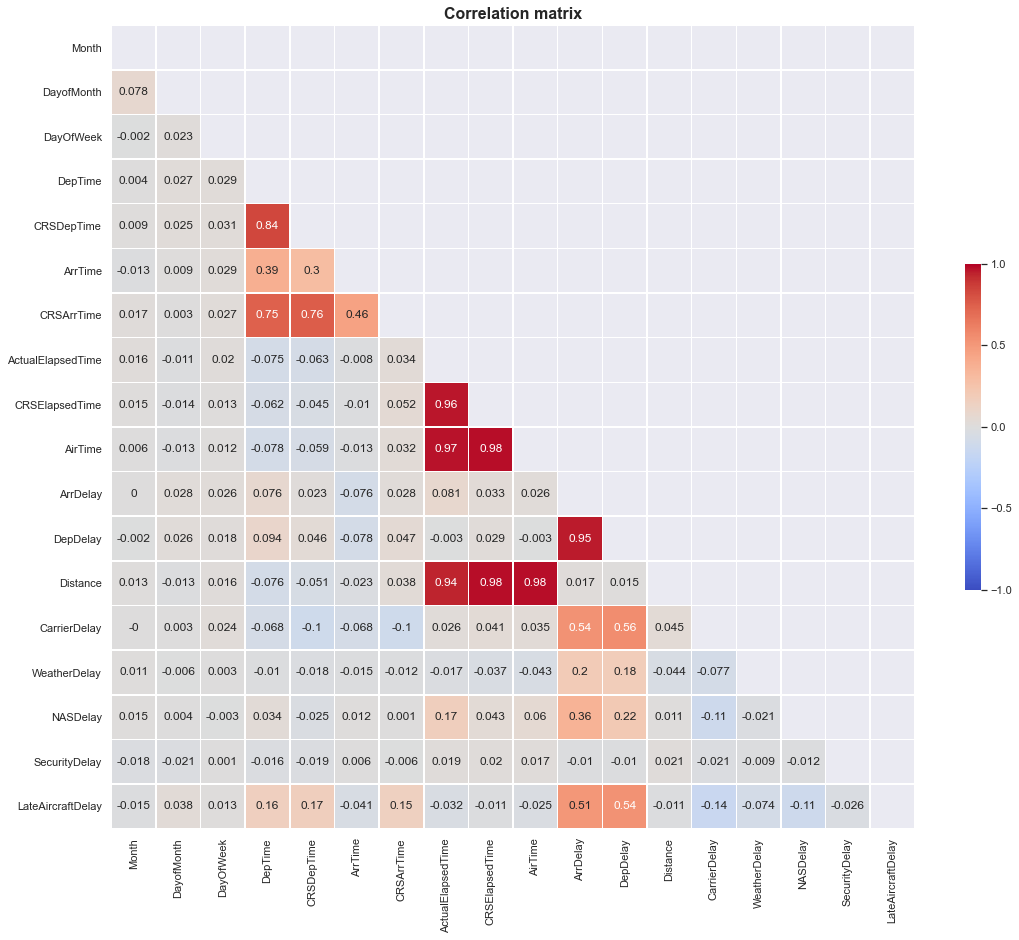

In [13]:
sns.set_theme()
corrmat = round(df_sample.corr(),3)
f, ax = plt.subplots(figsize=(18, 15))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
heatmap = sns.heatmap(corrmat, 
                      mask = mask,
                      square =True,
                      linewidths = .5,
                      ax=ax,
                      cmap = "coolwarm",
                      cbar_kws = {'shrink': .4, "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
plt.title("Correlation matrix", fontsize=16, fontweight="bold")

__*ArrDelay*__ has a strong relationship with DepDelay (0,96); __In a second level__ with the variables: CarrierDelay (0,57), WheatherDelay(0,2), NasDelay (0,35) and LateAircraftDelay (0,497). __Finally,__ with lower correlation are: DepTime (0,087), ActualElapsedTime (0,073).

Because of the 3rd exercice requirement, we do not include DepDelay

In [15]:
# Selecting only the columns with linear correlation that can be usefull for the analysis.
df2 = df_sample.loc[ : , ['ArrDelay','DepTime', 'ActualElapsedTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]

__Distribution graph__ of selected variables

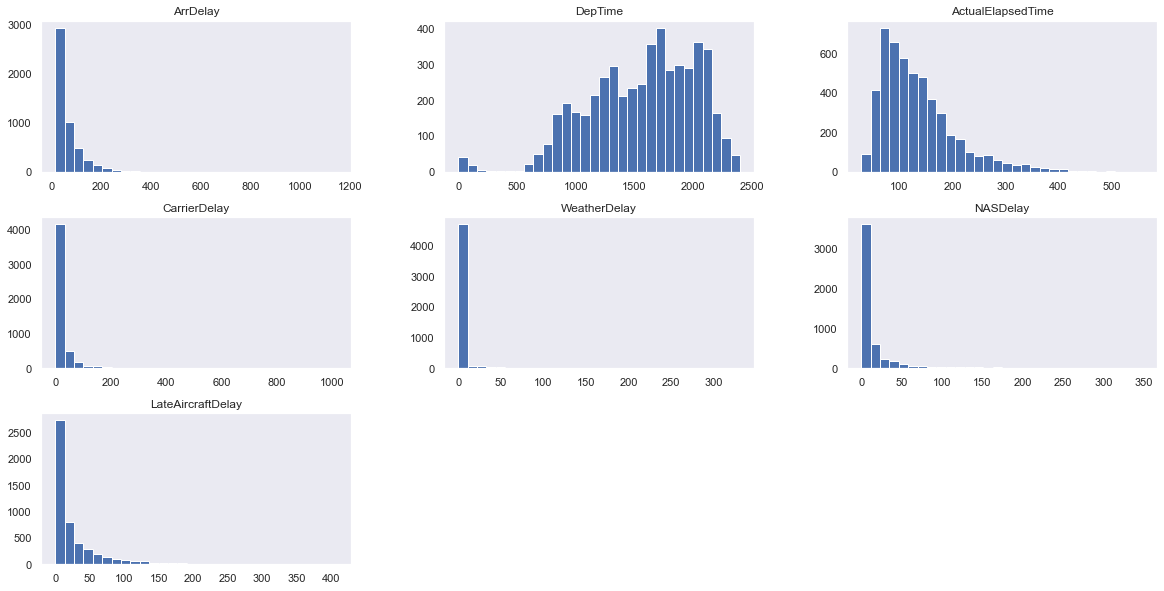

In [16]:
df2.hist(grid=False,
       figsize=(20, 10),
       bins=30);

# Nivell 1. 
### Exercici 1. Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.
### Exercici 2. Compara’ls en base al MSE i al R2.
### Exercici 3. Entrena’ls utilitzant els diferents paràmetres que admeten
### Exercici 4. Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)

In [17]:
# Defining predictors and outcome variables
x = df2[['DepTime', 'ActualElapsedTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = df2["ArrDelay"]

In [18]:
X = sm.add_constant(x)

In [19]:
# Split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=123)

In [20]:
X_train.head()

,const,DepTime,ActualElapsedTime,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
1819144,1.0,1326.0,107.0,8.0,0.0,0.0,71.0
1502151,1.0,1301.0,497.0,16.0,0.0,12.0,0.0
1844253,1.0,1208.0,131.0,0.0,0.0,0.0,39.0
1730156,1.0,1648.0,300.0,69.0,0.0,0.0,0.0
744896,1.0,2220.0,114.0,1.0,0.0,0.0,33.0


In [21]:
y_train.head()

1819144    79.0
1502151    28.0
1844253    39.0
1730156    69.0
744896     34.0
Name: ArrDelay, dtype: float64

__Multiple Linear Regression__

*For a regression model we will use the Ordinary Least Square Method (OLS)*   

__Y = β0 + β1 x1 + … + βk xk + ε__

In [22]:
# performing the regression
# and fitting the model
modelprueba = sm.OLS(y_train, X_train).fit()

# printing the summary table
print(modelprueba.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.904e+05
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:21:59   Log-Likelihood:                -8383.8
No. Observations:                3750   AIC:                         1.678e+04
Df Residuals:                    3743   BIC:                         1.683e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0587      0.15

*DepTime and ActualElapsedTime, as predictors have very low impact in the model*, __the P>|t|__ value means that in both cases there are not statistically significant contribution. They can be removed from the model.

__R-squared:__ It signifies the “percentage variation in dependent that is explained by independent variables”. In the model it is 0,998, that means the model is almost perfect. But we need to check other statistics.

__Omnibus:__ one of the assumption of OLS is normality distribution. Prob(Omnibus) is supposed to be close to the 1 in order for it to satisfy the OLS assumption. In this case Prob(Omnibus) is far of 1, which implies that the OLS assumption is not satisfied. 

__Durbin-watson:__ Another assumption of OLS is of homoscedasticity. This implies that the variance of errors is constant. A value between 1 to 2 is preferred. Here, it is very close to 2 (2.003) implying that the regression results can be reliable from the interpretation side of this metric. So, we don’t have to do anything.

In [23]:
# Defining predictors and outcome variables
x = df2[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = df2["ArrDelay"]
X = sm.add_constant(x)
# Split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=123)
# performing the regression
# and fitting the model
modelOLS = sm.OLS(y_train, X_train).fit()

# printing the summary table
print(modelOLS.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.352e+05
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:22:02   Log-Likelihood:                -8385.8
No. Observations:                3750   AIC:                         1.678e+04
Df Residuals:                    3745   BIC:                         1.681e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2086      0.05

*Any of the statistics has changed, just two variables have been removed.*

__*Calculate VIF factor:__ The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. 

The value for VIF starts at 1 and has no upper limit. But, __a value of 1__ indicates there is no correlation between a given explanatory variable and any other explanatory variables in the model; __a value between 1 and 5__ indicates moderate correlation between a given explanatory variable and other explanatory variables in the model; finally __a value greater than 5__ indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model. 


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [25]:
vif.round(1)  # nothing to do, there are not nulticollinearity between explanatory variables

,VIF Factor,features
0,2.1,const
1,1.0,CarrierDelay
2,1.0,WeatherDelay
3,1.0,NASDelay
4,1.0,LateAircraftDelay


The equation function with the test model is:

__Y = -0.0082 + 0.759 X1(CarrierDelay) + 0.7875 X2(WheatherDelay) + 0.3174 X3(NASDelay) + 0.4781 X4(LateAircraftDelay)__

In [26]:
y_predOLS = modelOLS.predict(X_test)

maeOLS = mean_absolute_error(y_test, y_predOLS)
mseOLS = mean_squared_error(y_test, y_predOLS)

# Printing the metrics
print('R2 square:', r2_score(y_test, y_predOLS))
print('MAE: ', maeOLS)
print('MSE: ', mseOLS)

R2 square: 0.9996684656076662
MAE:  0.19714357484861164
MSE:  1.106012657269961


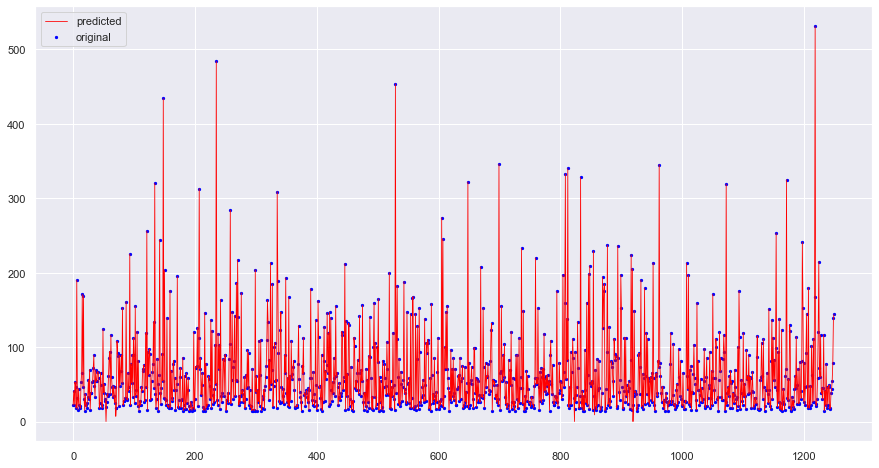

In [27]:
f, ax = plt.subplots(figsize=(15, 8))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predOLS, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

*For every predicted data we have the original one. As the model is perfect (R2=1) every predicted value has a original one perfectly fitted.*

__RANDOM FOREST__

In [28]:
x = df2[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = df2["ArrDelay"]
# Split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=123)

modelRF = RandomForestRegressor()
modelRF.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_predRF = modelRF.predict(X_test)
mae_RF = mean_absolute_error(y_test, y_predRF)
mse_RF = mean_squared_error(y_test, y_predRF)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', modelRF.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predRF))
print('MAE_RF: ', mae_RF)
print('MSE_RF: ', mse_RF)

Suppport Vector Regression Accuracy:  0.9840334221024798
R2 square: 0.9840334221024798
MAE_RF:  2.1628735744591157
MSE_RF:  53.26517446239902


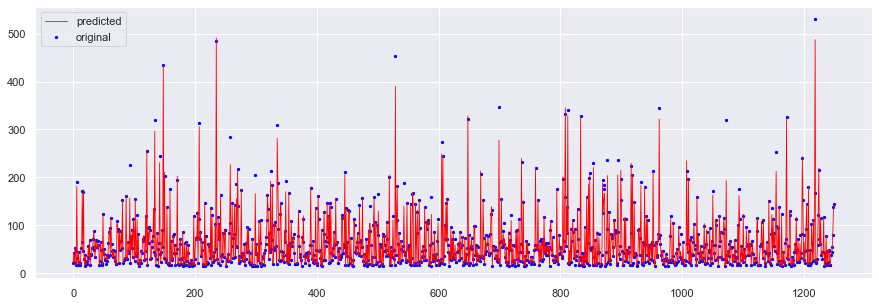

In [29]:
f, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predRF, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

*For every predicted data we have the original one*

*R² for the Randon Forest Regression is the estimated regression line fits the observed datapoints

*As the model has R2 close to one, every predicted value has a original one almost perfectly fitted.*

In [30]:
# Predictors importance by permutation

from sklearn.inspection import permutation_importance
importance = permutation_importance(
                estimator    = modelRF,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
Rf_importance = pd.DataFrame(
                    {k: importance[k] for k in ['importances_mean', 'importances_std']}
                 )
Rf_importance['feature'] = X_train.columns
Rf_importance.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
1,55.015050,0.370342,CarrierDelay
4,51.915960,0.639127,LateAircraftDelay
3,34.409923,0.299382,NASDelay
2,18.809455,0.363811,WeatherDelay
0,0.000000,0.000000,const


*The permutation_importance function calculates the feature importance of estimators for a given dataset.*

__Decision Tree Regressor__

In [31]:
x = df2[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = df2["ArrDelay"]

# Split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=123)

modelDTR = DecisionTreeRegressor(random_state=0)

cross_val_score(modelDTR, X_train, y_train, cv=10)
modelDTR.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [32]:
y_predDTR = modelDTR.predict(X_test)

mae_DTR = mean_absolute_error(y_test, y_predDTR)
mse_DTR = mean_squared_error(y_test, y_predDTR)

print('Suppport Vector Regression Accuracy: ', modelDTR.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predDTR))
print('maeDTR: ', mae_DTR)
print('mseDTR: ', mse_DTR)

Suppport Vector Regression Accuracy:  0.9770073841302342
R2 square: 0.9770073841302342
maeDTR:  2.9199272727272727
mseDTR:  76.70433223140496


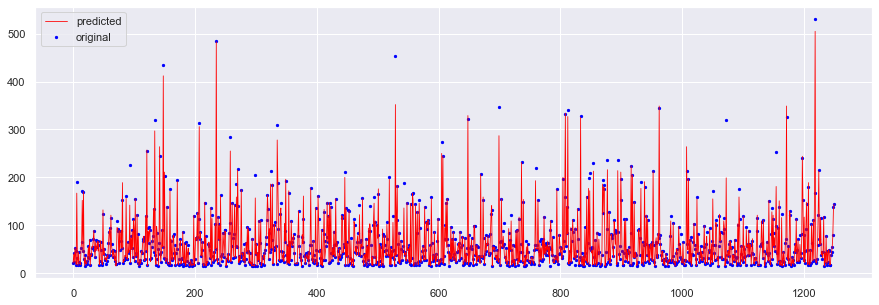

In [33]:
f, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predDTR, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

__Exercici 2. Compara’ls en base al MSE i al R2__

__Comparison with RSE and R2__

In [34]:
print("---------------------------")
print("Multiple Linear Regression:")
print("---------------------------")
print('R2 square:', r2_score(y_test, y_predOLS))
print('MAE: ', maeOLS)
print('MSE: ', mseOLS)

print("---------------------------")
print("Random Forest:")
print("---------------------------")
print('R2 square:', r2_score(y_test, y_predRF))
print('MAE_RF: ', mae_RF)
print('MSE_RF: ', mse_RF)

print("---------------------------")
print("Decision Tree Regressor:")
print("---------------------------")
print('R2 square:', r2_score(y_test, y_predDTR))
print('maeDTR: ', mae_DTR)
print('mseDTR: ', mse_DTR)


---------------------------
Multiple Linear Regression:
---------------------------
R2 square: 0.9996684656076662
MAE:  0.19714357484861164
MSE:  1.106012657269961
---------------------------
Random Forest:
---------------------------
R2 square: 0.9840334221024798
MAE_RF:  2.1628735744591157
MSE_RF:  53.26517446239902
---------------------------
Decision Tree Regressor:
---------------------------
R2 square: 0.9770073841302342
maeDTR:  2.9199272727272727
mseDTR:  76.70433223140496


*Multiple Linear Regression has the higher R2 (0.999) than the other two models.The statistics mae and mse are close to cero in the linear regression compared to the other two models.

__Exercici 3. Entrena’ls utilitzant els diferents paràmetres que admeten__

__Training with some possible parameters__

__LinearRegression__

In [36]:
from sklearn.linear_model import LinearRegression

# In the first model we use OSL but, in order to try with different parameters,
# We will use linearRegression.

# fit_intercept, bool, default=True
# normalize, bool, default=False
# n_jobs, int, default=None
# positive, bool, default=False

# performing the regression
# and fitting the model
modelLR = LinearRegression(normalize=True,
                          fit_intercept =False,
                          n_jobs =10,
                          positive = True
                          )
modelLR= sm.OLS(y_train, X_train).fit()

y_predLR = modelLR.predict(X_test)

maeLR = mean_absolute_error(y_test, y_predLR)
mseLR = mean_squared_error(y_test, y_predLR)

# printing the metrics
print('R2 square: ', r2_score(y_test, y_predLR))
print('MAE: ', maeLR)
print('MSE: ', mseLR)

R2 square:  0.9996684656076662
MAE:  0.19714357484861164
MSE:  1.106012657269961


*Any of the parameters admitted by the LinearRegression changes the results we already have. All the statistics keep its original values*

__Random Forest with different parameters__

In [37]:
RF_2 = RandomForestRegressor(n_estimators = 100 ,  criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 42)
RF_2.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_predRF2 = RF_2.predict(X_test)
mae_RF2 = mean_absolute_error(y_test, y_predRF2)
mse_RF2 = mean_squared_error(y_test, y_predRF2)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', RF_2.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predRF2))
print('MAE_RF: ', mae_RF2)
print('MSE_RF: ', mse_RF2)


Suppport Vector Regression Accuracy:  0.9839690297722032
R2 square: 0.9839690297722032
MAE_RF:  2.162949619657467
MSE_RF:  53.47998998067972


In [40]:
# n_estimators, int, default=100. changing the number of trees in the forest.
# criterion, {“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”. I have used "sme" that was deprecated since version 1.0
# So, I change it for "poisson" which uses reduction in Poisson deviance to find splits. 

RF_3 = RandomForestRegressor(n_estimators = 300 ,  criterion  = 'poisson',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
RF_3.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_predRF3 = RF_3.predict(X_test)
mae_RF3 = mean_absolute_error(y_test, y_predRF3)
mse_RF3 = mean_squared_error(y_test, y_predRF3)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', RF_3.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predRF3))
print('MAE_RF3: ', mae_RF3)
print('MSE_RF3: ', mse_RF3)

Suppport Vector Regression Accuracy:  0.9771039950347191
R2 square: 0.9771039950347191
MAE_RF3:  2.9220471238860215
MSE_RF3:  76.38203419638565


*Changing n_stimators from 100 to 300, random state from 42 to 123, does not really change the results. But, when the criterion was modified from "mse" to "posion", R2 changes from 0.98 to 0.97*

In [44]:
# min_samples_split, int or float, default=2
# max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”

RF_4 = RandomForestRegressor(n_estimators = 100 ,  criterion  = 'poisson',
            max_depth    = None,
            min_samples_split = 20,                 
            max_features = 'log2',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
RF_4.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_predRF4 = RF_4.predict(X_test)
mae_RF4 = mean_absolute_error(y_test, y_predRF4)
mse_RF4 = mean_squared_error(y_test, y_predRF4)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', RF_4.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predRF4))
print('MAE_RF: ', mae_RF4)
print('MSE_RF: ', mse_RF4)

Suppport Vector Regression Accuracy:  0.9564137195096939
R2 square: 0.9564137195096939
MAE_RF:  6.612525174661675
MSE_RF:  145.40566233944168


*The changes in the parameters max_features from "2" to "Log2" and the min_samples_split from "auto" to "20", and criterion "poisson", has a little effect in the R2. The graph below shows the difference between predicted and original data*

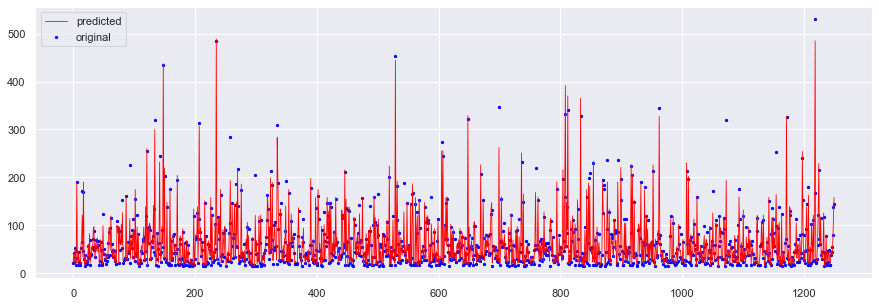

In [46]:
f, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predRF4, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

__Decision Tree Regression with different parameters__

In [48]:
# max_depth, int, default=None
# min_samples_split int or float, default=2

DTR2 = DecisionTreeRegressor(random_state = 0,
                            criterion = "poisson",
                            splitter = "best",
                            )

cross_val_score(modelDTR, X_train, y_train, cv=10)
DTR2.fit(X_train, y_train)

y_predDTR2 = DTR2.predict(X_test)

mae_DTR2 = mean_absolute_error(y_test, y_predDTR2)
mse_DTR2 = mean_squared_error(y_test, y_predDTR2)

print('Suppport Vector Regression Accuracy: ', DTR2.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predDTR))
print('maeDTR: ', mae_DTR2)
print('mseDTR: ', mse_DTR2)

Suppport Vector Regression Accuracy:  0.9740985478505951
R2 square: 0.9770073841302342
maeDTR:  3.175927272727273
mseDTR:  86.40833223140496


*changing parameters as random_state from 0 to 42 and splitter from default "best" to "random" does not change the main statistics of the model. But, adding criterion "poisson" and defining max_depth and min_samples_split does not produces  changes in the R2 (still 0,97), the main changes are produced in mae and mse statistics because before both were almost 0*

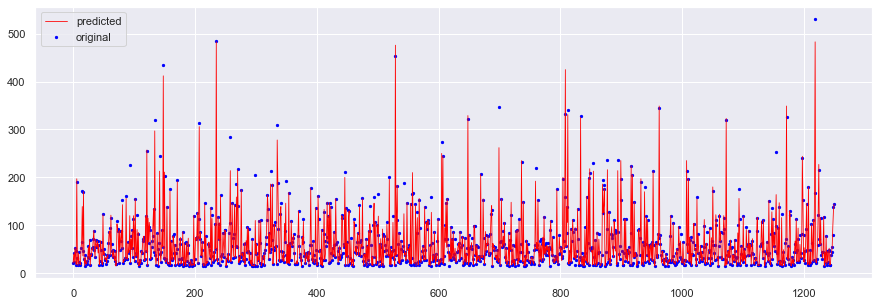

In [49]:
f, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predDTR2, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [50]:
# Doing more changes:
# max_depth, int, default=None
# min_samples_split int or float, default=2

DTR2 = DecisionTreeRegressor(random_state = 0,
                            splitter = "best",
                            criterion = "poisson",
                            max_depth = 20,
                            min_samples_split = 5
                            )

cross_val_score(modelDTR, X_train, y_train, cv=10)
DTR2.fit(X_train, y_train)

y_predDTR2 = DTR2.predict(X_test)

mae_DTR2 = mean_absolute_error(y_test, y_predDTR2)
mse_DTR2 = mean_squared_error(y_test, y_predDTR2)

print('Suppport Vector Regression Accuracy: ', DTR2.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predDTR))
print('maeDTR: ', mae_DTR2)
print('mseDTR: ', mse_DTR2)

Suppport Vector Regression Accuracy:  0.2851566896365433
R2 square: 0.9770073841302342
maeDTR:  36.109151244850445
mseDTR:  2384.7473067915266


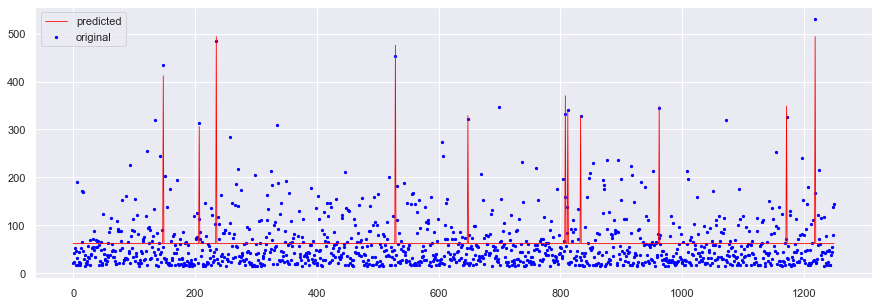

In [51]:
f, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predDTR2, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

*Finally, forcing the model with the criteriom "poisson" and adding max_depth =20 and min_samples_split = 5, the model reduces the accuracy and the errors: mae and mse rise.* 

__Exercici 4. Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)__

__Cross validation:__ Linear Regression

In [52]:
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
 
#Loading the dataset

x = df2[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = df2["ArrDelay"]

# Split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=123)


In [53]:
#Implementing cross validation
 
lr = LinearRegression()
lr.fit(X_train,y_train)

np.mean(cross_val_score(lr, X, y, cv=5))

0.9988348268806189

In [54]:
y_predict =lr.predict(X_test)

In [55]:
cv_r2_score_lr = cross_val_score(lr,X,y,cv = 5,scoring ='r2')
print("The accuracy of each fold: ", cv_r2_score_lr)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_score_lr)))

The accuracy of each fold:  [0.99971202 0.99931822 0.99954784 0.99867802 0.99691804]
Mean 5-Fold R Squared: 0.9988348268806189


__Cross validation:__ Random Forest

In [56]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [57]:
cv_r2_score_rf = cross_val_score(rf,X,y,cv=5,scoring='r2')
print(cv_r2_score_rf)
print('Decision Tree Regression Mean 5-Fold R squared:{}'.format(np.mean(cv_r2_score_rf)))

[0.793643   0.9789498  0.98192621 0.98700121 0.98926312]
Decision Tree Regression Mean 5-Fold R squared:0.9461566686947949


__Cross validation:__ Decision Tree Regressor

In [58]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [59]:
y_dtr_predict=dtr.predict(X_test)

cv_r2_score_dt = cross_val_score(dtr,X,y,cv=5,scoring='r2')
print(cv_r2_score_dt)
print('Decision Tree Regression Mean 5-Fold R squared:{}'.format(np.mean(cv_r2_score_dt)))

[0.76706442 0.97903091 0.97528839 0.98210024 0.97069747]
Decision Tree Regression Mean 5-Fold R squared:0.9348362834717874


### Nivell 2. Exercici 5. Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

In [60]:
# Scaling - normalization

dfnorm = pd.DataFrame(preprocessing.normalize(df2),columns=df2.columns)
dfnorm.head()

,ArrDelay,DepTime,ActualElapsedTime,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
0,0.069951,0.991096,0.091305,0.000000,0.0,0.002945,0.067006
1,0.014903,0.995643,0.090836,0.000000,0.0,0.000000,0.014903
2,0.141184,0.973683,0.109887,0.000000,0.0,0.141184,0.000000
3,0.008959,0.999396,0.032351,0.000000,0.0,0.008959,0.000000
4,0.093798,0.990388,0.039193,0.093798,0.0,0.000000,0.000000


In [61]:
# Linear regression
x = dfnorm[['CarrierDelay','WeatherDelay', 'NASDelay', 'LateAircraftDelay']]
y = dfnorm["ArrDelay"]
X = sm.add_constant(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [62]:
OLSnorm = sm.OLS(y_train, X_train).fit()

# printing the summary table
print(OLSnorm.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.458e+06
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:30:20   Log-Likelihood:                 19610.
No. Observations:                4000   AIC:                        -3.921e+04
Df Residuals:                    3995   BIC:                        -3.918e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0001   3.51e-0

In [63]:
y_predOLSnomr = OLSnorm.predict(X_test)

maeOLSnorm = mean_absolute_error(y_test, y_predOLSnomr)
mseOLSnorm = mean_squared_error(y_test, y_predOLSnomr)

# Printing the metrics
print('R2 square:', r2_score(y_test, y_predOLSnomr))
print('MAE: ', maeOLSnorm)
print('MSE: ', mseOLSnorm)

R2 square: 0.9996500821300378
MAE:  0.00013954366680711417
MSE:  1.0658697248216047e-06


In [64]:
# Random forest

RFnorm = RandomForestRegressor()
RFnorm.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_predRFnorm = RFnorm.predict(X_test)
mae_RFnorm = mean_absolute_error(y_test, y_predRFnorm)
mse_RFnorm = mean_squared_error(y_test, y_predRFnorm)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', RFnorm.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predRFnorm))
print('MAE_RF: ', mae_RFnorm)
print('MSE_RF: ', mse_RFnorm)


Suppport Vector Regression Accuracy:  0.9854919776651061
R2 square: 0.9854919776651061
MAE_RF:  0.0017509826402659515
MSE_RF:  4.41922608167121e-05


In [66]:
# Decision Tree Regressor

DTRnorm = DecisionTreeRegressor(random_state=0)

DTRnorm.fit(X_train, y_train)

y_predDTRnorm = DTRnorm.predict(X_test)

mae_DTRnorm = mean_absolute_error(y_test, y_predDTRnorm)
mse_DTRnorm = mean_squared_error(y_test, y_predDTRnorm)

print('Suppport Vector Regression Accuracy: ', DTRnorm.score(X_test,y_test))
print('R2 square:', r2_score(y_test, y_predDTRnorm))
print('maeDTR: ', mae_DTRnorm)
print('mseDTR: ', mse_DTRnorm)

Suppport Vector Regression Accuracy:  0.982157039632114
R2 square: 0.982157039632114
maeDTR:  0.0022678295106544877
mseDTR:  5.43506716572507e-05


Normalization processing rise a little bit the almost high R2 we obtain in the three models. 

Also, errors as mae and mse have been reduced in the three cases in small amounts.

It is important to take into account that the sum of all the predictors are equal of the dependent variable. That's why the regression model is accurate.

### Nivell 3. Exercici 6. No utilitzis la variable DepDelay a l’hora de fer prediccions. 

I did not use DepDelay in any case.